MTH4320 Poject 1: 3D_slAIcer

Mawaba Pascal Dao
Dr. White
Florida Institute of Technology
10/13/2021

In [2]:
import cv2
from mpl_toolkits import mplot3d
import meshcut
import matplotlib.pyplot as plt
from objSlicer import *
from obj2verts import *
from tqdm import tqdm
import os
import numpy as np
%matplotlib inline
# import itertools


'/home/pascal/3D_slAIcer/data/coseg/coseg_aliens/train/1.obj'

# Slices (labels)

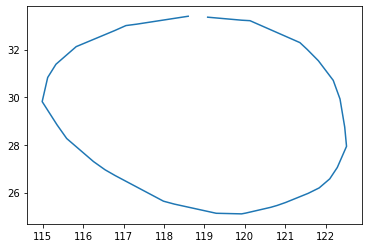

In [61]:

plotSlice(p_)

# Data Generation


## Input Features
The data for this project are edge features from OBJ CAD files. The OBJ files are from The Shape COSEG dataset: http://irc.cs.sdu.edu.cn/~yunhai/public_html/ssl/ssd.htm. I implemented classes to read the vertices and faces on an OBJ file and calculate edge features on which my model trains. 

<img src="doc/example_alient.png" width=200 height=200 />

Figure 1: Sample obj file from coseg dataset

We first read in a triangle mesh as list of faces and edges. This is done using the _readFile_ method from the Obj2verts class (obj2verts.py). 
Given a triangle mesh, we loop through all faces and the vertices that form those faces. An edge can be defined by 2 common edges of 2 adjascent triangles. This is done by the _findEdges_ method of Obj2verts. 

Once the edges are available, we must calculate the features of this edge. These are the features that will be used to train the model. Hanocka, et al [1] have implemented a meshCNN for the task of 3D mesh classification. meshCNN also learns on edge features. In [1] they define the following edge features:

<img src="doc/edge_features.png" width=200 height=200 />

Figure 2: The 5 edge features fron meshCNN [1]

* Dihedral angle: The Angle between the 2 adjascent faces that form the edge
* 2 Inner angles: The angles opposite to the edge
* 2 Edge-length ratios: The ratios of the length of the endge to the height of of the triangles

In meshCNN, each 2 face-based feature in sorted to avoid ordering ambiguity and ensure invariance.

In 3D_slAIcer we calculate the same features using the methods in obj2verts.py.

* Dihedral angle:

Given 2 faces, their normals are calculated using the cross product of 2 vectors on a face. Then, using the dot product formula
 $a.b = |a||b|cos(\theta)$ where a and b are the normal vectors. We solve for $\theta$ which gives us the dihedral angle

 * Inner angles: The inner angles are calculated using the dot product formula on the 2 edges of each face that are not shared with the adjascent face.

 * Edge-lenth ratio: To find the lenght of the base we just calculate the lenth of the vector between the 2 vertices that define an edge. Then to find the height of each triangle, we first use Heron's formula for the area of a triangle: $A = \sqrt{s(s-a)*s(s-b)*s(s-c)}$ where $s = (a+b+c)/2$ and $a, b, c$ are the length of each edge of the triangle. Then knowing the area and base length we calculate the height using $h = A*2/base$

 Therefore, the dimensionality of the inputs is $nx5$ where n is the number of edges in a mesh. To make this input size uniform for all meshes, we implement an edge pooling when processing the data before feeding it to the network. We first define an edge resolution of 450.  The 450 "strongest" edges (edges with the hihgest l2 norm), that is 1 edge per batch of $nEdges/resolution$ over all the edges in a mesh.

## Labels

The labels for each mesh is a single slice calculated by intersecting a cutting place with the mesh. The normal of the cutting plane points in the postive z direction and its origin is at the first vertex of the mesh. 

<img src="doc/2.obj.png" width=200 height=200 />

Figure 3: Example input triangle mesh

<img src="doc/2obj_slice.png" width=200 height=200 />

Figure 4: Example ground truth slice

The ground truth labels were generated using using the ObjSlicer class which calls the *cross_section_cut* method from meshcut.py[2].

[2] https://github.com/julienr/meshcut/blob/master/meshcut.py

<!-- ## Obj2MeshVerts in obj2verts.py:

Methods:

*  **readFile**:
    Takes in a file path and returns a geometry object containing a list of the vertices and triangles of the obj file
 
 ## ObjGeometry in obj2verts.py:

 Methods:

 * **calculateFeatures**:  -->

In [78]:

aliensTrainDir = os.path.join(os.getcwd(), 'data', 'coseg', 'coseg_aliens', 'train')
chairsTrainDir = os.path.join(os.getcwd(), 'data', 'coseg', 'coseg_chairs', 'train')
vasesTrainDir = os.path.join(os.getcwd(), 'data', 'coseg', 'coseg_vases', 'train')



trainDir = os.path.join(os.getcwd(), 'data', 'train')


# featuresDir = os.path.join(os.getcwd(), 'data', 'coseg', 'coseg_aliens', 'train', 'features')

trainDirs = [chairsTrainDir, vasesTrainDir]
print('--------------------------------------------')
print('Generating Train Data')
print('--------------------------------------------')
# trainDirs[0].split('/')[6]
# trainDirs
for directory in trainDirs:
    dataset = directory.split('/')[6]
    print('--------------------------------------------')
    print(dataset)
    print('--------------------------------------------')
    for filename in os.listdir(directory):
        if isObj(filename):
            print(filename)
            fileId = filename.split('.')[0]
            filePath = os.path.join(directory, filename)

            #Caclucate features and save as input data
            o2v = Obj2verts()
            geometry = o2v.readFile(filePath)
            features = geometry.calculateFeatures() #Calculate mesh features we want to learn on
            trainFile = os.path.join(trainDir, 'data', fileId+'_'+dataset+'.npy')
            np.save(trainFile, features)

            #Slice mesh and save as label
            cutting_plane_norm = (0, 0, 1)
            P = osl.singleSlice(filePath, cutting_plane_norm)
            if len(P) > 0:
                p = P[0] #Only keep one out of several polylines
                n = p.shape[0]
                #Upsample
                ps = cv2.resize(p, (3, 10000), interpolation=cv2.INTER_NEAREST)
                n = ps.shape[0]
                ps = ps[::int(n/200)]
                print(f'downsampled to {ps.shape}')
                labelFile = os.path.join(trainDir, 'labels', fileId+'_'+dataset+'.npy')
                np.save(labelFile, ps)

print('--------------------------------------------')
print('Generating Test Data')
print('--------------------------------------------')

aliensTestDir = os.path.join(
    os.getcwd(), 'data', 'coseg', 'coseg_aliens', 'test')
chairsTestDir = os.path.join(
    os.getcwd(), 'data', 'coseg', 'coseg_chairs', 'test')
vasesTestDir = os.path.join(
    os.getcwd(), 'data', 'coseg', 'coseg_vases', 'test')

testDir = os.path.join(os.getcwd(), 'data', 'test')

testDirs = [aliensTestDir, chairsTestDir, vasesTestDir]

for directory in testDirs:
    dataset = directory.split('/')[6]
    print('--------------------------------------------')
    print(dataset)
    print('--------------------------------------------')
    for filename in os.listdir(directory):
        if isObj(filename):
            print(filename)
            fileId = filename.split('.')[0]
            filePath = os.path.join(directory, filename)

            #Caclucate features and save as input data
            o2v = Obj2verts()
            geometry = o2v.readFile(filePath)
            # Calculate mesh features we want to learn on
            features = geometry.calculateFeatures()
            trainFile = os.path.join(
                testDir, 'data', fileId+'_'+dataset+'.npy')
            np.save(trainFile, features)

            #Slice mesh and save as label
            cutting_plane_norm = (0, 0, 1)
            P = osl.singleSlice(filePath, cutting_plane_norm)

            if len(P) > 0:
                p = P[0]  # Only keep one out of several polylines
                n = p.shape[0]
                #Upsample
                ps = cv2.resize(p, (3, 10000), interpolation=cv2.INTER_NEAREST)
                n = ps.shape[0]
                ps = ps[::int(n/200)]
                print(f'downsampled to {ps.shape}')
                labelFile = os.path.join(
                    testDir, 'labels', fileId+'_'+dataset+'.npy')
                np.save(labelFile, ps)


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.78it/s]

--------------------------------------------
Generating Train Data
--------------------------------------------
--------------------------------------------
coseg_chairs
--------------------------------------------
0127.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.09it/s]

downsampled to (200, 3)
0212.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.43it/s]

downsampled to (200, 3)
0220.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:31, 31.79it/s]

downsampled to (200, 3)
0305.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.67it/s]

downsampled to (200, 3)
0300.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.59it/s]

downsampled to (200, 3)
0218.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.65it/s]

downsampled to (200, 3)
0283.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.74it/s]

downsampled to (200, 3)
0342.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.95it/s]

downsampled to (200, 3)
0281.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.70it/s]

downsampled to (200, 3)
0165.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.09it/s]

downsampled to (200, 3)
0064.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.89it/s]

downsampled to (200, 3)
0182.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.87it/s]

downsampled to (200, 3)
0128.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.37it/s]

downsampled to (200, 3)
0209.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.89it/s]

downsampled to (200, 3)
0037.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.81it/s]

downsampled to (200, 3)
0279.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.03it/s]

downsampled to (200, 3)
0309.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.12it/s]

downsampled to (200, 3)
0333.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.48it/s]

downsampled to (200, 3)
0382.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 41.42it/s]

downsampled to (200, 3)
0025.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.36it/s]

downsampled to (200, 3)
0130.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.29it/s]

downsampled to (200, 3)
0079.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.24it/s]

downsampled to (200, 3)
0388.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.87it/s]

downsampled to (200, 3)
0210.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.17it/s]

downsampled to (200, 3)
0397.obj


Finding Edges...:   0%|          | 4/996 [00:00<00:27, 36.02it/s]

downsampled to (200, 3)
0081.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.14it/s]

downsampled to (200, 3)
0262.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.17it/s]

downsampled to (200, 3)
0126.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.60it/s]

downsampled to (200, 3)
0357.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.78it/s]

downsampled to (200, 3)
0175.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.44it/s]

downsampled to (200, 3)
0263.obj


Finding Edges...:   0%|          | 3/1000 [00:00<00:34, 28.83it/s]

downsampled to (200, 3)
0325.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.66it/s]

downsampled to (200, 3)
0206.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.57it/s]

downsampled to (200, 3)
0160.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.45it/s]

downsampled to (200, 3)
0290.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.80it/s]

downsampled to (200, 3)
0091.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.85it/s]

downsampled to (200, 3)
0070.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.03it/s]

downsampled to (200, 3)
0065.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.88it/s]

downsampled to (200, 3)
0228.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.16it/s]

downsampled to (200, 3)
0257.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.15it/s]

downsampled to (200, 3)
0335.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.36it/s]

downsampled to (200, 3)
0033.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.93it/s]

downsampled to (200, 3)
0085.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.59it/s]

downsampled to (200, 3)
0354.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.49it/s]

downsampled to (200, 3)
0298.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.69it/s]

downsampled to (200, 3)
0052.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.69it/s]

downsampled to (200, 3)
0058.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.56it/s]

downsampled to (200, 3)
0299.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.25it/s]

downsampled to (200, 3)
0367.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.33it/s]

downsampled to (200, 3)
0107.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:30, 32.76it/s]

downsampled to (200, 3)
0264.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.40it/s]

downsampled to (200, 3)
0353.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.11it/s]

downsampled to (200, 3)
0166.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 41.39it/s]

downsampled to (200, 3)
0192.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.99it/s]

downsampled to (200, 3)
0360.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.81it/s]

downsampled to (200, 3)
0099.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.04it/s]

downsampled to (200, 3)
0306.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.20it/s]

downsampled to (200, 3)
0005.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.65it/s]

downsampled to (200, 3)
0074.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.50it/s]

0251.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.64it/s]

downsampled to (200, 3)
0199.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.76it/s]

downsampled to (200, 3)
0067.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.34it/s]

downsampled to (200, 3)
0282.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.86it/s]

downsampled to (200, 3)
0075.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.02it/s]

downsampled to (200, 3)
0242.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.24it/s]

downsampled to (200, 3)
0188.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.01it/s]

downsampled to (200, 3)
0159.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.88it/s]

downsampled to (200, 3)
0113.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.85it/s]

downsampled to (200, 3)
0031.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.17it/s]

downsampled to (200, 3)
0322.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.99it/s]

downsampled to (200, 3)
0094.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.72it/s]

downsampled to (200, 3)
0392.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.79it/s]

downsampled to (200, 3)
0122.obj


Finding Edges...:   1%|          | 5/996 [00:00<00:21, 46.28it/s]

downsampled to (200, 3)
0066.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.66it/s]

downsampled to (200, 3)
0155.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.25it/s]

downsampled to (200, 3)
0098.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.88it/s]

downsampled to (200, 3)
0118.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.60it/s]

downsampled to (200, 3)
0369.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.73it/s]

downsampled to (200, 3)
0082.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.63it/s]

downsampled to (200, 3)
0356.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.07it/s]

downsampled to (200, 3)
0396.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.10it/s]

downsampled to (200, 3)
0371.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:24, 39.93it/s]

downsampled to (200, 3)
0261.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.94it/s]

downsampled to (200, 3)
0314.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.86it/s]

downsampled to (200, 3)
0201.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.31it/s]

downsampled to (200, 3)
0215.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.27it/s]

downsampled to (200, 3)
0231.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.16it/s]

downsampled to (200, 3)
0377.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.80it/s]

downsampled to (200, 3)
0023.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.40it/s]

downsampled to (200, 3)
0172.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.46it/s]

downsampled to (200, 3)
0288.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.03it/s]

downsampled to (200, 3)
0044.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.94it/s]

downsampled to (200, 3)
0181.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.39it/s]

downsampled to (200, 3)
0351.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.28it/s]

downsampled to (200, 3)
0041.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.49it/s]

downsampled to (200, 3)
0376.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.26it/s]

downsampled to (200, 3)
0077.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.31it/s]

downsampled to (200, 3)
0119.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.02it/s]

downsampled to (200, 3)
0111.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.83it/s]

downsampled to (200, 3)
0383.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.55it/s]

downsampled to (200, 3)
0054.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.63it/s]

downsampled to (200, 3)
0092.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.83it/s]

downsampled to (200, 3)
0180.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.15it/s]

downsampled to (200, 3)
0195.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.19it/s]

downsampled to (200, 3)
0038.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.99it/s]

downsampled to (200, 3)
0170.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.84it/s]

downsampled to (200, 3)
0173.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.57it/s]

downsampled to (200, 3)
0174.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.49it/s]

downsampled to (200, 3)
0312.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.27it/s]

downsampled to (200, 3)
0103.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.21it/s]

downsampled to (200, 3)
0109.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.09it/s]

downsampled to (200, 3)
0008.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.70it/s]

downsampled to (200, 3)
0095.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.81it/s]

downsampled to (200, 3)
0200.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 34.85it/s]

downsampled to (200, 3)
0030.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.91it/s]

downsampled to (200, 3)
0144.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.80it/s]

downsampled to (200, 3)
0147.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.12it/s]

downsampled to (200, 3)
0381.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.90it/s]

downsampled to (200, 3)
0252.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.93it/s]

downsampled to (200, 3)
0225.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 34.80it/s]

downsampled to (200, 3)
0076.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.97it/s]

downsampled to (200, 3)
0061.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.18it/s]

downsampled to (200, 3)
0334.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.56it/s]

downsampled to (200, 3)
0250.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.78it/s]

downsampled to (200, 3)
0063.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.95it/s]

downsampled to (200, 3)
0238.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 34.86it/s]

downsampled to (200, 3)
0304.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.58it/s]

downsampled to (200, 3)
0017.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.25it/s]

downsampled to (200, 3)
0010.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.63it/s]

downsampled to (200, 3)
0002.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:29, 34.02it/s]

downsampled to (200, 3)
0069.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.12it/s]

0040.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.36it/s]

downsampled to (200, 3)
0056.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.10it/s]

downsampled to (200, 3)
0302.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.43it/s]

downsampled to (200, 3)
0274.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.76it/s]

downsampled to (200, 3)
0234.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.72it/s]

downsampled to (200, 3)
0139.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 35.28it/s]

downsampled to (200, 3)
0112.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.61it/s]

downsampled to (200, 3)
0027.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:29, 34.04it/s]

downsampled to (200, 3)
0150.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.10it/s]

downsampled to (200, 3)
0202.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.48it/s]

downsampled to (200, 3)
0062.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.78it/s]

0276.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.48it/s]

downsampled to (200, 3)
0267.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.52it/s]

downsampled to (200, 3)
0194.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.41it/s]

downsampled to (200, 3)
0326.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.41it/s]

downsampled to (200, 3)
0015.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.02it/s]

downsampled to (200, 3)
0260.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.49it/s]

downsampled to (200, 3)
0232.obj


Finding Edges...:   0%|          | 3/1000 [00:00<00:41, 23.89it/s]

downsampled to (200, 3)
0084.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.43it/s]

downsampled to (200, 3)
0362.obj


Finding Edges...:   0%|          | 3/1000 [00:00<00:40, 24.39it/s]

downsampled to (200, 3)
0183.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 35.80it/s]

downsampled to (200, 3)
0137.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.19it/s]

downsampled to (200, 3)
0133.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.07it/s]

downsampled to (200, 3)
0154.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.27it/s]

downsampled to (200, 3)
0161.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.30it/s]

downsampled to (200, 3)
0034.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.11it/s]

downsampled to (200, 3)
0328.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.20it/s]

downsampled to (200, 3)
0068.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.43it/s]

downsampled to (200, 3)
0018.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.90it/s]

downsampled to (200, 3)
0233.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.47it/s]

downsampled to (200, 3)
0045.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.59it/s]

downsampled to (200, 3)
0373.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:25, 39.74it/s]

downsampled to (200, 3)
0116.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.69it/s]

downsampled to (200, 3)
0287.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.97it/s]

downsampled to (200, 3)
0293.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.12it/s]

downsampled to (200, 3)
0086.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.32it/s]

downsampled to (200, 3)
0311.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:29, 34.30it/s]

downsampled to (200, 3)
0016.obj


Finding Edges...:   0%|          | 3/1000 [00:00<00:39, 25.54it/s]

downsampled to (200, 3)
0235.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.24it/s]

downsampled to (200, 3)
0230.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.10it/s]

downsampled to (200, 3)
0004.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.01it/s]

downsampled to (200, 3)
0320.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.00it/s]

downsampled to (200, 3)
0313.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.57it/s]

downsampled to (200, 3)
0078.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.07it/s]

downsampled to (200, 3)
0340.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.47it/s]

downsampled to (200, 3)
0364.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.19it/s]

downsampled to (200, 3)
0007.obj


Finding Edges...:   0%|          | 3/1000 [00:00<00:40, 24.61it/s]

downsampled to (200, 3)
0003.obj


Finding Edges...:   0%|          | 3/1000 [00:00<00:44, 22.26it/s]

downsampled to (200, 3)
0319.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.47it/s]

downsampled to (200, 3)
0327.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.22it/s]

downsampled to (200, 3)
0198.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.57it/s]

downsampled to (200, 3)
0186.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.97it/s]

downsampled to (200, 3)
0032.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.29it/s]

downsampled to (200, 3)
0141.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.99it/s]

downsampled to (200, 3)
0318.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.28it/s]

downsampled to (200, 3)
0285.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.55it/s]

downsampled to (200, 3)
0366.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.10it/s]

downsampled to (200, 3)
0246.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.72it/s]

downsampled to (200, 3)
0196.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.84it/s]

downsampled to (200, 3)
0121.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.46it/s]

downsampled to (200, 3)
0134.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.77it/s]

downsampled to (200, 3)
0343.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.51it/s]

downsampled to (200, 3)
0013.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:30, 32.88it/s]

downsampled to (200, 3)
0289.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.18it/s]

downsampled to (200, 3)
0241.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.02it/s]

downsampled to (200, 3)
0026.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.07it/s]

downsampled to (200, 3)
0060.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 35.24it/s]

downsampled to (200, 3)
0387.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.61it/s]

downsampled to (200, 3)
0047.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.14it/s]

downsampled to (200, 3)
0135.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.19it/s]

downsampled to (200, 3)
0185.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.49it/s]

downsampled to (200, 3)
0157.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.63it/s]

downsampled to (200, 3)
0125.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.80it/s]

downsampled to (200, 3)
0393.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.37it/s]

downsampled to (200, 3)
0301.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.98it/s]

downsampled to (200, 3)
0363.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.76it/s]

downsampled to (200, 3)
0213.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:29, 33.72it/s]

downsampled to (200, 3)
0253.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.52it/s]

downsampled to (200, 3)
0386.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.91it/s]

downsampled to (200, 3)
0375.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:24, 39.92it/s]

downsampled to (200, 3)
0080.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.54it/s]

downsampled to (200, 3)
0105.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.26it/s]

downsampled to (200, 3)
0380.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.26it/s]

downsampled to (200, 3)
0229.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.38it/s]

downsampled to (200, 3)
0117.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.03it/s]

downsampled to (200, 3)
0073.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 41.23it/s]

downsampled to (200, 3)
0043.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.58it/s]

downsampled to (200, 3)
0046.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.98it/s]

downsampled to (200, 3)
0296.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.17it/s]

downsampled to (200, 3)
0255.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:30, 33.15it/s]

downsampled to (200, 3)
0395.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.34it/s]

downsampled to (200, 3)
0097.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.76it/s]

downsampled to (200, 3)
0131.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.90it/s]

downsampled to (200, 3)
0143.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.71it/s]

downsampled to (200, 3)
0163.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.21it/s]

downsampled to (200, 3)
0087.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.63it/s]

downsampled to (200, 3)
0269.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:31, 31.83it/s]

downsampled to (200, 3)
0219.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.07it/s]

downsampled to (200, 3)
0020.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.94it/s]

downsampled to (200, 3)
0169.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.56it/s]

downsampled to (200, 3)
0385.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.80it/s]

downsampled to (200, 3)
0339.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.39it/s]

downsampled to (200, 3)
0303.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.56it/s]

downsampled to (200, 3)
0221.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.86it/s]

downsampled to (200, 3)
0114.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.01it/s]

downsampled to (200, 3)
0365.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.83it/s]

downsampled to (200, 3)
0071.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.49it/s]

downsampled to (200, 3)
0106.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.36it/s]

downsampled to (200, 3)
0352.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.29it/s]

downsampled to (200, 3)
0009.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.18it/s]

downsampled to (200, 3)
0256.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 34.94it/s]

downsampled to (200, 3)
0129.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.11it/s]

downsampled to (200, 3)
0336.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.90it/s]

downsampled to (200, 3)
0217.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.33it/s]

downsampled to (200, 3)
0036.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.17it/s]

downsampled to (200, 3)
0096.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.98it/s]

downsampled to (200, 3)
0349.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.44it/s]

downsampled to (200, 3)
0227.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.79it/s]

downsampled to (200, 3)
0177.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.67it/s]

downsampled to (200, 3)
0286.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.24it/s]

downsampled to (200, 3)
0140.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.23it/s]

downsampled to (200, 3)
0291.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.18it/s]

downsampled to (200, 3)
0187.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.87it/s]

downsampled to (200, 3)
0370.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:19, 49.96it/s]

downsampled to (200, 3)
0197.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.71it/s]

downsampled to (200, 3)
0222.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.16it/s]

downsampled to (200, 3)
0399.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.56it/s]

downsampled to (200, 3)
0011.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:19, 49.98it/s]

downsampled to (200, 3)
0271.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.45it/s]

downsampled to (200, 3)
0359.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.73it/s]

downsampled to (200, 3)
0348.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.52it/s]

downsampled to (200, 3)
0389.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.24it/s]

downsampled to (200, 3)
0142.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.08it/s]

downsampled to (200, 3)
0273.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.98it/s]

downsampled to (200, 3)
0324.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.57it/s]

downsampled to (200, 3)
0006.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.25it/s]

downsampled to (200, 3)
0024.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.35it/s]

downsampled to (200, 3)
0158.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.44it/s]

downsampled to (200, 3)
0368.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.38it/s]

downsampled to (200, 3)
0100.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.57it/s]

downsampled to (200, 3)
0204.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.94it/s]

downsampled to (200, 3)
0012.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.88it/s]

downsampled to (200, 3)
0323.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.43it/s]

downsampled to (200, 3)
0029.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.99it/s]

downsampled to (200, 3)
0270.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.71it/s]

downsampled to (200, 3)
0249.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.05it/s]

downsampled to (200, 3)
0152.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.59it/s]

downsampled to (200, 3)
0057.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.59it/s]

downsampled to (200, 3)
0316.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.68it/s]

downsampled to (200, 3)
0355.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.17it/s]

downsampled to (200, 3)
0178.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.33it/s]

downsampled to (200, 3)
0145.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.16it/s]

downsampled to (200, 3)
0120.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.00it/s]

downsampled to (200, 3)
0156.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.53it/s]

downsampled to (200, 3)
0102.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.79it/s]

downsampled to (200, 3)
0223.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.76it/s]

downsampled to (200, 3)
0138.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.57it/s]

downsampled to (200, 3)
0048.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.86it/s]

downsampled to (200, 3)
0203.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.57it/s]

downsampled to (200, 3)
0390.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.30it/s]

downsampled to (200, 3)
0379.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.43it/s]

downsampled to (200, 3)
0297.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.52it/s]

downsampled to (200, 3)
0378.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.33it/s]

downsampled to (200, 3)
0110.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.65it/s]

downsampled to (200, 3)
0148.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.66it/s]

downsampled to (200, 3)
0244.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.46it/s]

downsampled to (200, 3)
0149.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.90it/s]

downsampled to (200, 3)
0115.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:24, 39.84it/s]

downsampled to (200, 3)
0329.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.94it/s]

downsampled to (200, 3)
0284.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.06it/s]

downsampled to (200, 3)
0042.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.55it/s]

downsampled to (200, 3)
0211.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.86it/s]

downsampled to (200, 3)
0146.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.59it/s]

downsampled to (200, 3)
0277.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.44it/s]

downsampled to (200, 3)
0050.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.86it/s]

downsampled to (200, 3)
0358.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.80it/s]

downsampled to (200, 3)
0372.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.67it/s]

downsampled to (200, 3)
0179.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:24, 39.89it/s]

downsampled to (200, 3)
0205.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.85it/s]

downsampled to (200, 3)
0239.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.63it/s]

downsampled to (200, 3)
0292.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.79it/s]

downsampled to (200, 3)
0331.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.64it/s]

downsampled to (200, 3)
0001.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.14it/s]

downsampled to (200, 3)
0344.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.94it/s]

downsampled to (200, 3)
0019.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.03it/s]

downsampled to (200, 3)
0088.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.06it/s]

downsampled to (200, 3)
0240.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.84it/s]

downsampled to (200, 3)
0248.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.14it/s]

downsampled to (200, 3)
0208.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.64it/s]

downsampled to (200, 3)
0226.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.45it/s]

downsampled to (200, 3)
0268.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 36.92it/s]

downsampled to (200, 3)
0224.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.71it/s]

downsampled to (200, 3)
0258.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.94it/s]

downsampled to (200, 3)
0028.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.40it/s]

downsampled to (200, 3)
0124.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.53it/s]

downsampled to (200, 3)
0337.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.78it/s]

downsampled to (200, 3)
0391.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.27it/s]

downsampled to (200, 3)
0167.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.93it/s]

downsampled to (200, 3)
0338.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.66it/s]

downsampled to (200, 3)
0247.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.19it/s]

downsampled to (200, 3)
0236.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.73it/s]

downsampled to (200, 3)
0214.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 41.31it/s]

downsampled to (200, 3)
0164.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.54it/s]

downsampled to (200, 3)
0294.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.23it/s]

downsampled to (200, 3)
0039.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.88it/s]

downsampled to (200, 3)
0307.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.16it/s]

downsampled to (200, 3)
--------------------------------------------
coseg_vases
--------------------------------------------
0127.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.41it/s]

downsampled to (200, 3)
0212.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.69it/s]

downsampled to (200, 3)
0220.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 41.34it/s]

downsampled to (200, 3)
0218.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.48it/s]

downsampled to (200, 3)
0283.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.02it/s]

downsampled to (200, 3)
0281.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.08it/s]

downsampled to (200, 3)
0090.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.65it/s]

downsampled to (200, 3)
0165.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 35.01it/s]

downsampled to (200, 3)
0064.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.12it/s]

downsampled to (200, 3)
0182.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.03it/s]

downsampled to (200, 3)
0128.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.82it/s]

downsampled to (200, 3)
0209.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.92it/s]

downsampled to (200, 3)
0037.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.06it/s]

downsampled to (200, 3)
0279.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:19, 49.93it/s]

downsampled to (200, 3)
0025.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.94it/s]

downsampled to (200, 3)
0083.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.98it/s]

downsampled to (200, 3)
0130.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.61it/s]

downsampled to (200, 3)
0079.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.80it/s]

downsampled to (200, 3)
0237.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 35.45it/s]

downsampled to (200, 3)
0210.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.89it/s]

downsampled to (200, 3)
0262.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.86it/s]

downsampled to (200, 3)
0126.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.15it/s]

downsampled to (200, 3)
0263.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.70it/s]

downsampled to (200, 3)
0160.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.93it/s]

downsampled to (200, 3)
0290.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.54it/s]

downsampled to (200, 3)
0091.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.47it/s]

downsampled to (200, 3)
0070.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.92it/s]

downsampled to (200, 3)
0065.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.44it/s]

downsampled to (200, 3)
0259.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.19it/s]

downsampled to (200, 3)
0228.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.64it/s]

downsampled to (200, 3)
0257.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.42it/s]

downsampled to (200, 3)
0033.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.33it/s]

downsampled to (200, 3)
0085.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.58it/s]

downsampled to (200, 3)
0298.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.03it/s]

downsampled to (200, 3)
0052.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.23it/s]

downsampled to (200, 3)
0193.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.71it/s]

downsampled to (200, 3)
0280.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.41it/s]

downsampled to (200, 3)
0058.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.15it/s]

downsampled to (200, 3)
0264.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.66it/s]

downsampled to (200, 3)
0166.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.75it/s]

downsampled to (200, 3)
0099.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.74it/s]

downsampled to (200, 3)
0005.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.26it/s]

downsampled to (200, 3)
0074.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.64it/s]

downsampled to (200, 3)
0251.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 50.68it/s]

downsampled to (200, 3)
0199.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.33it/s]

downsampled to (200, 3)
0067.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.80it/s]

downsampled to (200, 3)
0282.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.06it/s]

downsampled to (200, 3)
0075.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.10it/s]

downsampled to (200, 3)
0159.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.96it/s]

downsampled to (200, 3)
0275.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.64it/s]

downsampled to (200, 3)
0113.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.40it/s]

downsampled to (200, 3)
0031.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.21it/s]

downsampled to (200, 3)
0094.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.80it/s]

downsampled to (200, 3)
0066.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.71it/s]

downsampled to (200, 3)
0155.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.56it/s]

downsampled to (200, 3)
0098.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.35it/s]

downsampled to (200, 3)
0118.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.15it/s]

downsampled to (200, 3)
0082.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.31it/s]

downsampled to (200, 3)
0261.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.87it/s]

downsampled to (200, 3)
0201.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.77it/s]

downsampled to (200, 3)
0231.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.69it/s]

downsampled to (200, 3)
0023.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.74it/s]

downsampled to (200, 3)
0172.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.37it/s]

downsampled to (200, 3)
0044.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.97it/s]

downsampled to (200, 3)
0181.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 35.90it/s]

downsampled to (200, 3)
0041.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.06it/s]

downsampled to (200, 3)
0207.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.98it/s]

downsampled to (200, 3)
0077.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.64it/s]

downsampled to (200, 3)
0119.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:24, 39.92it/s]

downsampled to (200, 3)
0111.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.84it/s]

downsampled to (200, 3)
0054.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.41it/s]

downsampled to (200, 3)
0180.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.00it/s]

downsampled to (200, 3)
0195.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:28, 35.45it/s]

downsampled to (200, 3)
0038.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.42it/s]

downsampled to (200, 3)
0173.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.35it/s]

downsampled to (200, 3)
0266.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.81it/s]

downsampled to (200, 3)
0174.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.77it/s]

downsampled to (200, 3)
0109.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.44it/s]

downsampled to (200, 3)
0008.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.02it/s]

downsampled to (200, 3)
0095.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.20it/s]

downsampled to (200, 3)
0200.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.48it/s]

downsampled to (200, 3)
0030.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:29, 33.24it/s]

downsampled to (200, 3)
0144.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.35it/s]

downsampled to (200, 3)
0147.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.99it/s]

downsampled to (200, 3)
0252.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.43it/s]

downsampled to (200, 3)
0225.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.59it/s]

downsampled to (200, 3)
0076.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.75it/s]

downsampled to (200, 3)
0061.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.88it/s]

downsampled to (200, 3)
0250.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.48it/s]

downsampled to (200, 3)
0063.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.45it/s]

downsampled to (200, 3)
0238.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.07it/s]

downsampled to (200, 3)
0176.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.18it/s]

downsampled to (200, 3)
0017.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.79it/s]

downsampled to (200, 3)
0010.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.03it/s]

downsampled to (200, 3)
0002.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.58it/s]

downsampled to (200, 3)
0069.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.58it/s]

downsampled to (200, 3)
0040.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.08it/s]

downsampled to (200, 3)
0056.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.29it/s]

downsampled to (200, 3)
0274.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.68it/s]

downsampled to (200, 3)
0234.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.52it/s]

downsampled to (200, 3)
0139.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:29, 33.35it/s]

downsampled to (200, 3)
0112.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.43it/s]

downsampled to (200, 3)
0027.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.82it/s]

downsampled to (200, 3)
0202.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.46it/s]

downsampled to (200, 3)
0062.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:24, 39.91it/s]

downsampled to (200, 3)
0276.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.81it/s]

downsampled to (200, 3)
0267.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.84it/s]

downsampled to (200, 3)
0194.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.50it/s]

downsampled to (200, 3)
0015.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.34it/s]

downsampled to (200, 3)
0260.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.01it/s]

downsampled to (200, 3)
0232.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.74it/s]

downsampled to (200, 3)
0254.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.26it/s]

downsampled to (200, 3)
0084.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.79it/s]

downsampled to (200, 3)
0137.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.37it/s]

downsampled to (200, 3)
0133.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.76it/s]

downsampled to (200, 3)
0154.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.49it/s]

downsampled to (200, 3)
0034.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.34it/s]

downsampled to (200, 3)
0068.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.48it/s]

downsampled to (200, 3)
0018.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.33it/s]

downsampled to (200, 3)
0233.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 35.71it/s]

downsampled to (200, 3)
0045.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.11it/s]

downsampled to (200, 3)
0278.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.68it/s]

downsampled to (200, 3)
0116.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 41.12it/s]

downsampled to (200, 3)
0287.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.41it/s]

downsampled to (200, 3)
0265.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.87it/s]

downsampled to (200, 3)
0293.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.74it/s]

downsampled to (200, 3)
0016.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.43it/s]

downsampled to (200, 3)
0235.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.09it/s]

downsampled to (200, 3)
0230.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.17it/s]

downsampled to (200, 3)
0004.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.29it/s]

downsampled to (200, 3)
0078.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.21it/s]

downsampled to (200, 3)
0007.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.02it/s]

downsampled to (200, 3)
0003.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.30it/s]

downsampled to (200, 3)
0191.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.02it/s]

downsampled to (200, 3)
0198.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.91it/s]

downsampled to (200, 3)
0186.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.98it/s]

downsampled to (200, 3)
0243.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.50it/s]

downsampled to (200, 3)
0032.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.10it/s]

downsampled to (200, 3)
0141.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.72it/s]

downsampled to (200, 3)
0285.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.53it/s]

downsampled to (200, 3)
0246.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.93it/s]

downsampled to (200, 3)
0196.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.04it/s]

downsampled to (200, 3)
0121.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.98it/s]

downsampled to (200, 3)
0134.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.28it/s]

downsampled to (200, 3)
0013.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.08it/s]

downsampled to (200, 3)
0289.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.59it/s]

downsampled to (200, 3)
0241.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.59it/s]

downsampled to (200, 3)
0026.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.35it/s]

downsampled to (200, 3)
0216.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.87it/s]

downsampled to (200, 3)
0060.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.72it/s]

downsampled to (200, 3)
0047.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.78it/s]

downsampled to (200, 3)
0185.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.96it/s]

downsampled to (200, 3)
0157.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.68it/s]

downsampled to (200, 3)
0125.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.02it/s]

downsampled to (200, 3)
0153.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.80it/s]

downsampled to (200, 3)
0213.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.44it/s]

downsampled to (200, 3)
0162.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.27it/s]

downsampled to (200, 3)
0080.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.37it/s]

downsampled to (200, 3)
0105.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.26it/s]

downsampled to (200, 3)
0229.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.73it/s]

downsampled to (200, 3)
0117.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.55it/s]

downsampled to (200, 3)
0073.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.38it/s]

downsampled to (200, 3)
0043.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.48it/s]

downsampled to (200, 3)
0046.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.81it/s]

downsampled to (200, 3)
0296.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.48it/s]

downsampled to (200, 3)
0255.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.45it/s]

downsampled to (200, 3)
0097.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.60it/s]

downsampled to (200, 3)
0143.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.35it/s]

downsampled to (200, 3)
0163.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.51it/s]

downsampled to (200, 3)
0087.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:24, 40.86it/s]

downsampled to (200, 3)
0269.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.88it/s]

downsampled to (200, 3)
0219.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.61it/s]

downsampled to (200, 3)
0020.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.30it/s]

downsampled to (200, 3)
0136.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.56it/s]

downsampled to (200, 3)
0169.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.00it/s]

downsampled to (200, 3)
0101.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.24it/s]

downsampled to (200, 3)
0221.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.44it/s]

downsampled to (200, 3)
0114.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.14it/s]

downsampled to (200, 3)
0071.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.84it/s]

downsampled to (200, 3)
0106.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 38.12it/s]

downsampled to (200, 3)
0009.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.16it/s]

downsampled to (200, 3)
0256.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.78it/s]

downsampled to (200, 3)
0129.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.45it/s]

downsampled to (200, 3)
0217.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.41it/s]

downsampled to (200, 3)
0036.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.47it/s]

downsampled to (200, 3)
0096.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.12it/s]

downsampled to (200, 3)
0227.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.42it/s]

downsampled to (200, 3)
0177.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.52it/s]

downsampled to (200, 3)
0286.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.57it/s]

downsampled to (200, 3)
0140.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.93it/s]

downsampled to (200, 3)
0291.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.73it/s]

downsampled to (200, 3)
0187.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.32it/s]

downsampled to (200, 3)
0197.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.92it/s]

downsampled to (200, 3)
0222.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.67it/s]

downsampled to (200, 3)
0011.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.77it/s]

downsampled to (200, 3)
0142.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.19it/s]

downsampled to (200, 3)
0132.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.99it/s]

downsampled to (200, 3)
0273.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.93it/s]

downsampled to (200, 3)
0006.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.77it/s]

downsampled to (200, 3)
0024.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.54it/s]

downsampled to (200, 3)
0158.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.56it/s]

downsampled to (200, 3)
0204.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.72it/s]

downsampled to (200, 3)
0171.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.31it/s]

downsampled to (200, 3)
0108.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.25it/s]

downsampled to (200, 3)
0012.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.78it/s]

downsampled to (200, 3)
0029.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.69it/s]

downsampled to (200, 3)
0270.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.26it/s]

downsampled to (200, 3)
0249.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.46it/s]

downsampled to (200, 3)
0168.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.57it/s]

downsampled to (200, 3)
0057.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.27it/s]

downsampled to (200, 3)
0123.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.38it/s]

downsampled to (200, 3)
0178.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 36.97it/s]

downsampled to (200, 3)
0145.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.58it/s]

downsampled to (200, 3)
0120.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.51it/s]

downsampled to (200, 3)
0156.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.38it/s]

downsampled to (200, 3)
0102.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.65it/s]

downsampled to (200, 3)
0223.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.91it/s]

downsampled to (200, 3)
0138.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.31it/s]

downsampled to (200, 3)
0048.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.49it/s]

downsampled to (200, 3)
0203.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.67it/s]

downsampled to (200, 3)
0151.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.79it/s]

downsampled to (200, 3)
0297.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.54it/s]

downsampled to (200, 3)
0110.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.06it/s]

downsampled to (200, 3)
0148.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.98it/s]

downsampled to (200, 3)
0149.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.43it/s]

downsampled to (200, 3)
0245.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.99it/s]

downsampled to (200, 3)
0115.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.47it/s]

downsampled to (200, 3)
0284.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 38.73it/s]

downsampled to (200, 3)
0042.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.58it/s]

downsampled to (200, 3)
0211.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.82it/s]

downsampled to (200, 3)
0146.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.79it/s]

downsampled to (200, 3)
0179.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.26it/s]

downsampled to (200, 3)
0205.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.40it/s]

downsampled to (200, 3)
0239.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:26, 37.74it/s]

downsampled to (200, 3)
0292.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.32it/s]

downsampled to (200, 3)
0001.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.10it/s]

downsampled to (200, 3)
0019.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.17it/s]

downsampled to (200, 3)
0240.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.02it/s]

downsampled to (200, 3)
0248.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 35.93it/s]

downsampled to (200, 3)
0208.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 42.03it/s]

downsampled to (200, 3)
0226.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.76it/s]

downsampled to (200, 3)
0268.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.81it/s]

downsampled to (200, 3)
0224.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:27, 36.51it/s]

downsampled to (200, 3)
0028.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.54it/s]

downsampled to (200, 3)
0124.obj


Finding Edges...:   0%|          | 4/1000 [00:00<00:25, 39.84it/s]

downsampled to (200, 3)
0272.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 44.62it/s]

downsampled to (200, 3)
0247.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 43.43it/s]

downsampled to (200, 3)
0214.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 43.09it/s]

downsampled to (200, 3)
0093.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.08it/s]

downsampled to (200, 3)
0164.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 45.87it/s]

downsampled to (200, 3)
0294.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.91it/s]

downsampled to (200, 3)
0039.obj


Finding Edges...:   0%|          | 3/1500 [00:00<00:54, 27.50it/s]

downsampled to (200, 3)
--------------------------------------------
Generating Test Data
--------------------------------------------
--------------------------------------------
coseg_aliens
--------------------------------------------
178.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:42, 35.09it/s]

downsampled to (200, 3)
60.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:42, 35.39it/s]

downsampled to (200, 3)
89.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:43, 34.11it/s]

downsampled to (200, 3)
53.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:43, 34.40it/s]

downsampled to (200, 3)
146.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:39, 37.94it/s]

downsampled to (200, 3)
132.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:42, 35.11it/s]

downsampled to (200, 3)
93.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:46, 32.29it/s]

downsampled to (200, 3)
118.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:45, 32.82it/s]

downsampled to (200, 3)
55.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:40, 36.59it/s]

downsampled to (200, 3)
35.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 36.24it/s]

downsampled to (200, 3)
23.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 35.96it/s]

downsampled to (200, 3)
92.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 35.86it/s]

downsampled to (200, 3)
111.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 36.02it/s]

downsampled to (200, 3)
99.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 35.93it/s]

downsampled to (200, 3)
63.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:40, 37.15it/s]

downsampled to (200, 3)
36.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:45, 33.01it/s]

downsampled to (200, 3)
10.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:39, 37.57it/s]

downsampled to (200, 3)
192.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:40, 36.52it/s]

downsampled to (200, 3)
163.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:45, 33.05it/s]

downsampled to (200, 3)
28.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:42, 35.53it/s]

downsampled to (200, 3)
142.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 35.69it/s]

downsampled to (200, 3)
182.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:42, 35.43it/s]

downsampled to (200, 3)
189.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:42, 34.94it/s]

downsampled to (200, 3)
150.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:39, 37.57it/s]

downsampled to (200, 3)
166.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:44, 33.94it/s]

downsampled to (200, 3)
179.obj


Finding Edges...:   0%|          | 4/1499 [00:00<00:47, 31.37it/s]

downsampled to (200, 3)
117.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:41, 36.25it/s]

downsampled to (200, 3)
191.obj


Finding Edges...:   0%|          | 4/1500 [00:00<00:39, 37.50it/s]

downsampled to (200, 3)
195.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 55.15it/s]

downsampled to (200, 3)
--------------------------------------------
coseg_chairs
--------------------------------------------
0332.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.05it/s]

downsampled to (200, 3)
0090.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.48it/s]

downsampled to (200, 3)
0400.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.37it/s]

downsampled to (200, 3)
0237.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 55.22it/s]

downsampled to (200, 3)
0347.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.19it/s]

downsampled to (200, 3)
0310.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.81it/s]

downsampled to (200, 3)
0350.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.53it/s]

downsampled to (200, 3)
0317.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.17it/s]

downsampled to (200, 3)
0259.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.16it/s]

downsampled to (200, 3)
0059.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.98it/s]

downsampled to (200, 3)
0341.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.21it/s]

downsampled to (200, 3)
0193.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 55.12it/s]

downsampled to (200, 3)
0361.obj


Finding Edges...:   1%|          | 6/996 [00:00<00:18, 53.97it/s]

downsampled to (200, 3)
0089.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.30it/s]

downsampled to (200, 3)
0275.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.45it/s]

downsampled to (200, 3)
0021.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.50it/s]

downsampled to (200, 3)
0051.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.44it/s]

downsampled to (200, 3)
0072.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.60it/s]

downsampled to (200, 3)
0207.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.09it/s]

downsampled to (200, 3)
0266.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.57it/s]

downsampled to (200, 3)
0049.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.80it/s]

downsampled to (200, 3)
0053.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 55.49it/s]

downsampled to (200, 3)
0176.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.87it/s]

downsampled to (200, 3)
0189.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 55.43it/s]

downsampled to (200, 3)
0022.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 57.13it/s]

downsampled to (200, 3)
0254.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.38it/s]

downsampled to (200, 3)
0374.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.99it/s]

downsampled to (200, 3)
0014.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.48it/s]

downsampled to (200, 3)
0278.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.17it/s]

downsampled to (200, 3)
0308.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.71it/s]

downsampled to (200, 3)
0265.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 49.88it/s]

downsampled to (200, 3)
0191.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.58it/s]

downsampled to (200, 3)
0243.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.65it/s]

downsampled to (200, 3)
0295.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.81it/s]

downsampled to (200, 3)
0055.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.25it/s]

downsampled to (200, 3)
0398.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.30it/s]

downsampled to (200, 3)
0216.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.09it/s]

downsampled to (200, 3)
0153.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:19, 49.98it/s]

downsampled to (200, 3)
0162.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.77it/s]

downsampled to (200, 3)
0384.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.89it/s]

downsampled to (200, 3)
0315.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.44it/s]

downsampled to (200, 3)
0136.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 47.03it/s]

downsampled to (200, 3)
0101.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 52.27it/s]

downsampled to (200, 3)
0345.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.33it/s]

downsampled to (200, 3)
0104.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.80it/s]

downsampled to (200, 3)
0394.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 52.27it/s]

downsampled to (200, 3)
0132.obj


Finding Edges...:   1%|          | 5/999 [00:00<00:20, 47.63it/s]

downsampled to (200, 3)
0171.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.16it/s]

downsampled to (200, 3)
0108.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.99it/s]

downsampled to (200, 3)
0168.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.68it/s]

downsampled to (200, 3)
0123.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.81it/s]

downsampled to (200, 3)
0151.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.80it/s]

downsampled to (200, 3)
0035.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.07it/s]

downsampled to (200, 3)
0330.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.56it/s]

downsampled to (200, 3)
0245.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 47.87it/s]

downsampled to (200, 3)
0190.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.95it/s]

downsampled to (200, 3)
0321.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.11it/s]

downsampled to (200, 3)
0272.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.07it/s]

downsampled to (200, 3)
0346.obj


Finding Edges...:   1%|          | 6/996 [00:00<00:17, 56.51it/s]

downsampled to (200, 3)
0093.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.88it/s]

downsampled to (200, 3)
--------------------------------------------
coseg_vases
--------------------------------------------
0300.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.42it/s]

downsampled to (200, 3)
0081.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.90it/s]

downsampled to (200, 3)
0175.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.51it/s]

downsampled to (200, 3)
0206.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.68it/s]

downsampled to (200, 3)
0059.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.69it/s]

downsampled to (200, 3)
0299.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.64it/s]

downsampled to (200, 3)
0107.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:21, 46.26it/s]

downsampled to (200, 3)
0192.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.95it/s]

downsampled to (200, 3)
0242.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 55.58it/s]

downsampled to (200, 3)
0089.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 55.18it/s]

downsampled to (200, 3)
0188.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.67it/s]

downsampled to (200, 3)
0122.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 56.01it/s]

downsampled to (200, 3)
0021.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.06it/s]

downsampled to (200, 3)
0215.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.89it/s]

downsampled to (200, 3)
0288.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.92it/s]

downsampled to (200, 3)
0051.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.45it/s]

downsampled to (200, 3)
0072.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.40it/s]

downsampled to (200, 3)
0092.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:19, 51.80it/s]

downsampled to (200, 3)
0170.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.08it/s]

downsampled to (200, 3)
0103.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 55.64it/s]

downsampled to (200, 3)
0049.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.99it/s]

downsampled to (200, 3)
0053.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.56it/s]

downsampled to (200, 3)
0150.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 49.51it/s]

downsampled to (200, 3)
0189.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:20, 48.33it/s]

downsampled to (200, 3)
0022.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.77it/s]

downsampled to (200, 3)
0161.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.90it/s]

downsampled to (200, 3)
0014.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.38it/s]

downsampled to (200, 3)
0295.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:17, 55.26it/s]

downsampled to (200, 3)
0055.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.15it/s]

downsampled to (200, 3)
0135.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.66it/s]

downsampled to (200, 3)
0253.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.19it/s]

downsampled to (200, 3)
0131.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:22, 45.16it/s]

downsampled to (200, 3)
0271.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:19, 49.98it/s]

downsampled to (200, 3)
0104.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.04it/s]

downsampled to (200, 3)
0100.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.62it/s]

downsampled to (200, 3)
0152.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.78it/s]

downsampled to (200, 3)
0244.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 55.05it/s]

downsampled to (200, 3)
0035.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.87it/s]

downsampled to (200, 3)
0277.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.04it/s]

downsampled to (200, 3)
0190.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.07it/s]

downsampled to (200, 3)
0050.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 54.08it/s]

downsampled to (200, 3)
0088.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 52.76it/s]

downsampled to (200, 3)
0258.obj


Finding Edges...:   1%|          | 6/1000 [00:00<00:18, 53.23it/s]

downsampled to (200, 3)
0167.obj


Finding Edges...:   0%|          | 5/1000 [00:00<00:23, 41.92it/s]

downsampled to (200, 3)
0236.obj


Calculating Features...: 100%|██████████| 3000/3000 [00:00<00:00, 4458.46it/s]


downsampled to (200, 3)


In [79]:
# np.load('/home/pascal/3D_slAIcer/data/coseg/coseg_aliens/train/features/1.npy')
int(2.22)


2